In [20]:
import pandas as pd


AAPL


title  \
0  INTERNATIONAL PATENT: APPLE INC. FILES APPLICA...   
1  INTERNATIONAL PATENT: APPLE INC. FILES APPLICA...   
2  Apple Hospitality REIT, Inc. ( NYSE :APLE) Sha...   
3   Apple ( NASDAQ :AAPL) Cut to "Buy" at BidaskClub   
4    Apple, Best Stock Of 2020, Surges Into New Year   

                             source               author        date  \
0                       US Fed News                  NaN  2021-01-01   
1                       US Fed News                  NaN  2021-01-01   
2                        Zolmax.com                  NaN  2021-01-01   
3  American Banking and Market News                  NaN  2021-01-01   
4                     24/7 Wall St.  Douglas A. McIntyre  2021-01-01   

      length  wordcount  totalsearchresults  relevancescore  \
0  262 words        262                  10              62   
1  285 words        285                  10              57   
2  795 words        795                  10              50   
3  995 words        995                  10              30   
4  669 words        669                  10              25   

   contentcomponentid vendorreportid  \
0              282801     USFDNW2021   
1              282801     USFDNW2021   
2              484302    AMCN-116308   
3              439934     AMBNWS2021   
4              484220       TFS-5001   

                                          docid  
0  urn:contentItem:61N5-PKX1-F12F-F1DG-00000-00  
1  urn:contentItem:61N8-CWB1-F12F-F3VS-00000-00  
2  urn:contentItem:61NB-DBD1-JCMN-Y0BG-00000-00  
3  urn:contentItem:61NC-6WB1-JB40-X3PR-00000-00  
4  urn:contentItem:61NB-DBD1-JCMN-Y1XM-00000-00

In [36]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from collections import Counter
import os
import matplotlib.pyplot as plt

tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, truncation=True, padding=True)

def process_content(content):
    tokens = tokenizer.tokenize(content)
    max_length = 512 - tokenizer.num_special_tokens_to_add()
    token_chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    
    sentiments = []
    for chunk in token_chunks:
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        part_sentiment = nlp(chunk_text[0:513])

        sentiments.extend(part_sentiment)

    # Aggregate sentiments by majority voting
    label_counts = Counter([sentiment['label'] for sentiment in sentiments])
    most_common_label, _ = label_counts.most_common(1)[0]
    
    # Dynamically compute average scores for a more nuanced aggregation
    scores = {}
    for sentiment in sentiments:
        label = sentiment['label']
        if label in scores:
            scores[label] += sentiment['score']
        else:
            scores[label] = sentiment['score']
    
    for label in scores.keys():
        scores[label] /= len(token_chunks)
    print(scores)
    final_label = max(scores, key=scores.get)

    if final_label == 'Positive':
        value = 3
    elif final_label == 'Neutral':
        value = 2
    elif final_label == 'Negative':
        value = 1
    
    return {'label': final_label, 'score': scores[final_label], 'value' : value}

def processData(df):
    results = []
    for content in df['title']:
        processed_result = process_content(content)
        results.append(processed_result)

    df['Sentiment'] = results
    return df

def labelExtract(df):
    # Extract 'label', 'score', and 'value' keys into new columns
    df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: x.get('label', 'N/A'))
    df['Sentiment_Score'] = df['Sentiment'].apply(lambda x: x.get('score', 0))
    df['Sentiment_Value'] = df['Sentiment'].apply(lambda x: x.get('value', 'N/A'))
    
    return df

def sentimentIndexByDay(df, companyName):
    df['Sentiment_index'] = df['Sentiment_Score'] * df['Sentiment_Value']
    sentiment_index_by_day = df.groupby('date')['Sentiment_index'].mean()
    
    sentiment_index_by_day.to_csv(f'{companyName}_sentiment_index.csv')

    return sentiment_index_by_day


def Plot(sentiment_index_by_day, companyName):
    # Plotting the sentiment index by day
    plt.figure(figsize=(18, 10))
    plt.plot(sentiment_index_by_day.index, sentiment_index_by_day.values)
    plt.xlabel('Date')
    plt.ylabel('Sentiment Index')
    plt.title(f'Sentiment Index for {companyName} by Day')
    plt.xticks(rotation=45)
    plt.xticks(range(0, len(sentiment_index_by_day.index), 10), sentiment_index_by_day.index[::10])
    plt.show()


In [31]:
companyName = "newsdata\AAPL_21-01_24-04_news"
companyName = companyName.split('_')[0]
print(companyName)
print(companyName.split('\\')[1])

newsdata\AAPL
AAPL


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


AAPL
{'Neutral': 0.9993489384651184}
{'Neutral': 0.9988136291503906}
{'Neutral': 0.9999785423278809}
{'Neutral': 0.8815215229988098}
{'Positive': 0.9999982118606567}
{'Positive': 1.0}
{'Neutral': 0.9991810917854309}
{'Neutral': 0.9698077440261841}
{'Neutral': 0.9999958276748657}
{'Neutral': 0.9999732971191406}
{'Positive': 0.9949384927749634}
{'Positive': 0.9844144582748413}
{'Negative': 0.9999045133590698}
{'Positive': 0.9053192138671875}
{'Positive': 0.7428536415100098}
{'Neutral': 0.9999688863754272}
{'Neutral': 0.9990443587303162}
{'Neutral': 0.9984738230705261}
{'Neutral': 0.9995424747467041}
{'Positive': 0.786440908908844}
{'Neutral': 0.9999843835830688}
{'Neutral': 0.9999973773956299}
{'Neutral': 0.9985370635986328}
{'Neutral': 0.9999550580978394}
{'Neutral': 0.9977108240127563}
{'Neutral': 0.9996509552001953}
{'Neutral': 0.9999390840530396}
{'Negative': 0.8652473092079163}
{'Neutral': 0.9999747276306152}
{'Neutral': 0.9999892711639404}
{'Neutral': 0.9999793767929077}
{'Neutral'

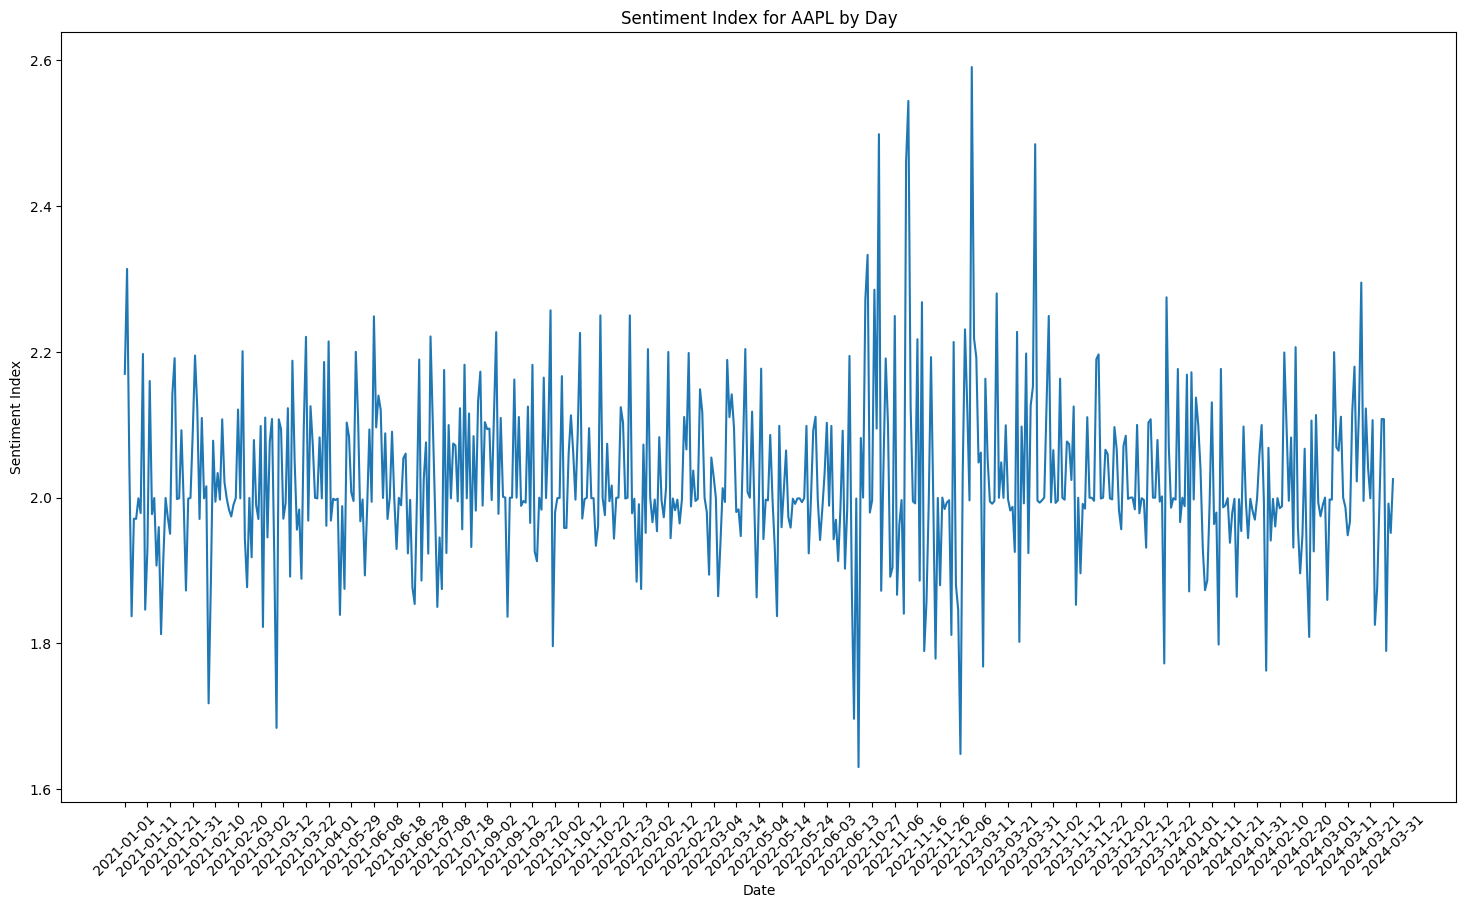

AXP
{'Positive': 0.9658315181732178}
{'Neutral': 0.999991774559021}
{'Neutral': 0.9998362064361572}
{'Neutral': 0.9965869188308716}
{'Neutral': 0.999923825263977}
{'Neutral': 0.9999959468841553}
{'Neutral': 0.9834408760070801}
{'Neutral': 0.9999899864196777}
{'Neutral': 0.9903566241264343}
{'Neutral': 0.9999958276748657}
{'Positive': 0.9978432655334473}
{'Positive': 0.999847412109375}
{'Neutral': 0.9183195233345032}
{'Positive': 0.9999990463256836}
{'Positive': 0.9953224062919617}
{'Neutral': 0.9988754391670227}
{'Neutral': 0.9999209642410278}
{'Neutral': 0.8921201229095459}
{'Neutral': 0.999954342842102}
{'Neutral': 0.9998944997787476}
{'Neutral': 0.9999243021011353}
{'Neutral': 0.9999544620513916}
{'Neutral': 0.4793686270713806}
{'Neutral': 0.6270110011100769}
{'Neutral': 0.9999463558197021}
{'Neutral': 0.9999550580978394}
{'Neutral': 0.9977911710739136}
{'Neutral': 0.999991774559021}
{'Positive': 0.5318482518196106}
{'Positive': 0.999998927116394}
{'Neutral': 0.9999213218688965}
{'N

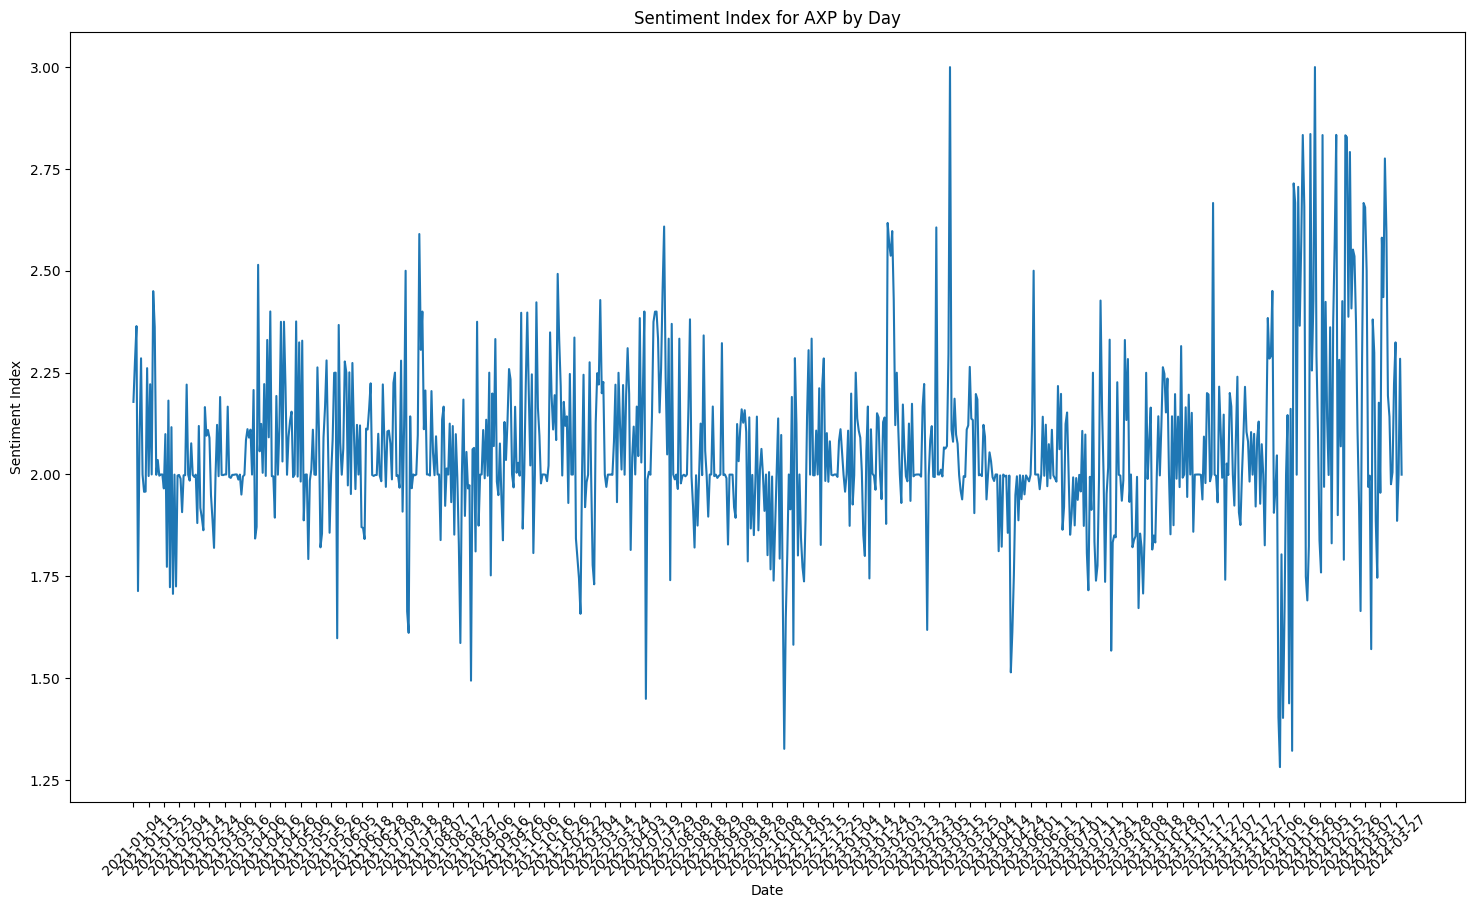

BAC
{'Neutral': 0.9993841648101807}
{'Positive': 0.9971513152122498}
{'Positive': 0.9743530750274658}
{'Positive': 0.988431453704834}
{'Neutral': 0.9999908208847046}
{'Neutral': 0.9999983310699463}
{'Positive': 0.9952998161315918}
{'Neutral': 0.9999938011169434}
{'Positive': 0.9998598098754883}
{'Neutral': 0.9994445443153381}
{'Neutral': 0.8849839568138123}
{'Positive': 0.999868631362915}
{'Neutral': 0.9999088048934937}
{'Neutral': 0.9999829530715942}
{'Neutral': 0.9999336004257202}
{'Neutral': 0.9999610185623169}
{'Positive': 0.9021937847137451}
{'Negative': 0.9999464750289917}
{'Neutral': 0.9999518394470215}
{'Positive': 0.9999887943267822}
{'Positive': 0.9998804330825806}
{'Positive': 0.999240517616272}
{'Neutral': 0.9999970197677612}
{'Neutral': 0.9999887943267822}
{'Neutral': 0.9998937845230103}
{'Negative': 0.9999940395355225}
{'Neutral': 0.9905812740325928}
{'Neutral': 0.9999861717224121}
{'Neutral': 0.9999487400054932}
{'Neutral': 0.999988317489624}
{'Neutral': 0.99999618530273

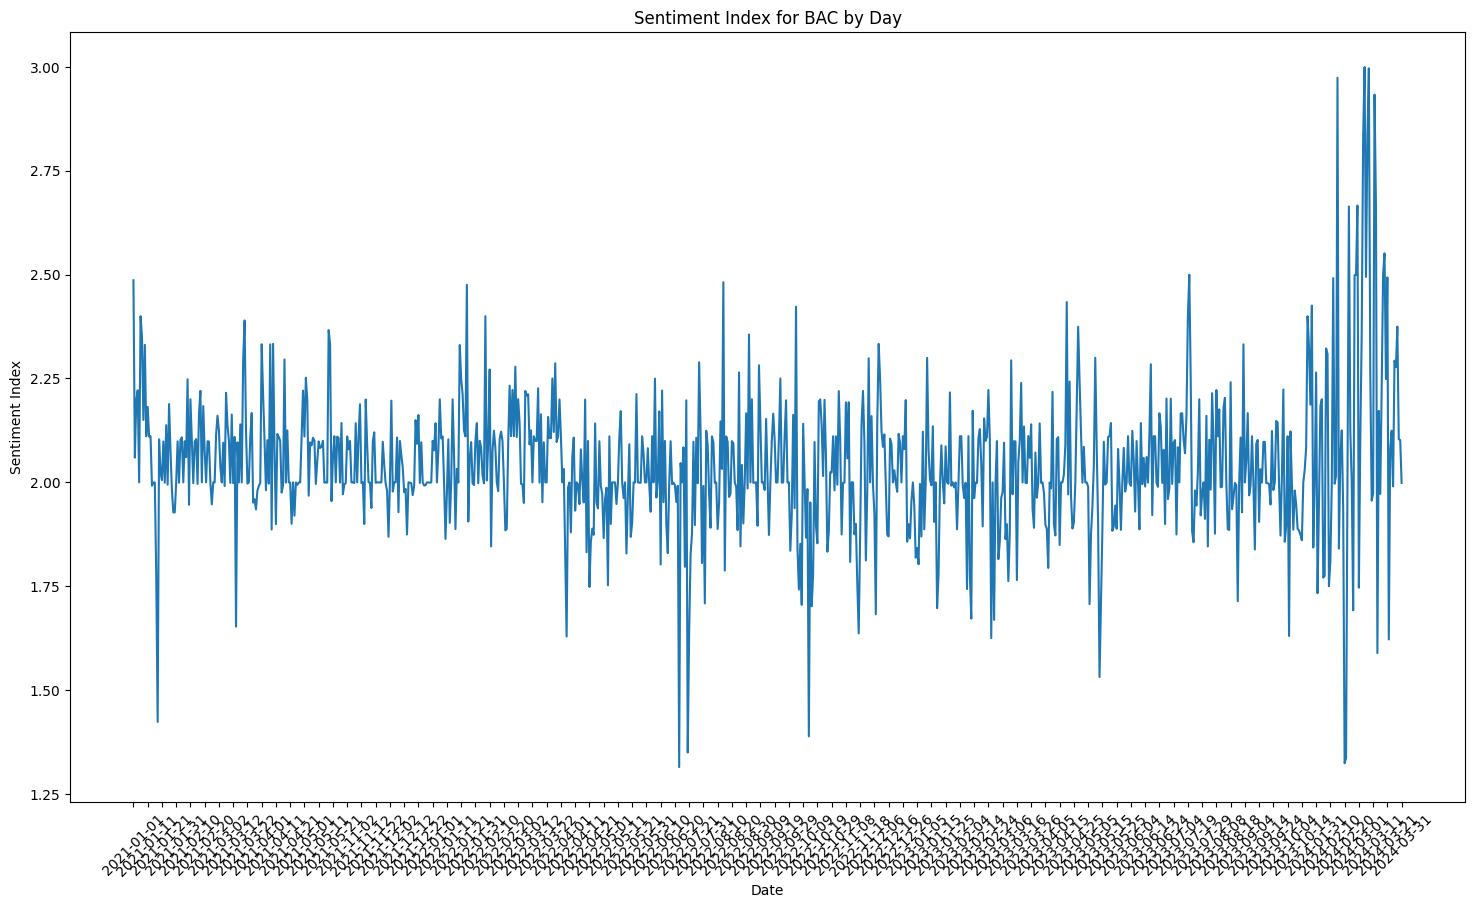

BLK
{'Neutral': 0.999994158744812}
{'Neutral': 0.9852197170257568}
{'Neutral': 0.9995597004890442}
{'Neutral': 0.9974141120910645}
{'Neutral': 0.9998537302017212}
{'Neutral': 0.9999840259552002}
{'Neutral': 0.998996913433075}
{'Neutral': 0.9999041557312012}
{'Neutral': 0.9776819348335266}
{'Neutral': 0.9943959712982178}
{'Neutral': 0.999554455280304}
{'Neutral': 0.9999853372573853}
{'Positive': 0.88444983959198}
{'Neutral': 0.9999810457229614}
{'Neutral': 0.9999399185180664}
{'Neutral': 0.9999983310699463}
{'Neutral': 0.9998787641525269}
{'Neutral': 0.999988317489624}
{'Neutral': 0.9996449947357178}
{'Neutral': 0.9999587535858154}
{'Neutral': 0.9999908208847046}
{'Neutral': 0.9999775886535645}
{'Neutral': 0.999774158000946}
{'Neutral': 0.9999978542327881}
{'Neutral': 0.9999898672103882}
{'Neutral': 0.5871221423149109}
{'Neutral': 0.9995676875114441}
{'Positive': 0.9934754967689514}
{'Neutral': 0.9999533891677856}
{'Neutral': 0.9999912977218628}
{'Neutral': 0.9999921321868896}
{'Neutral

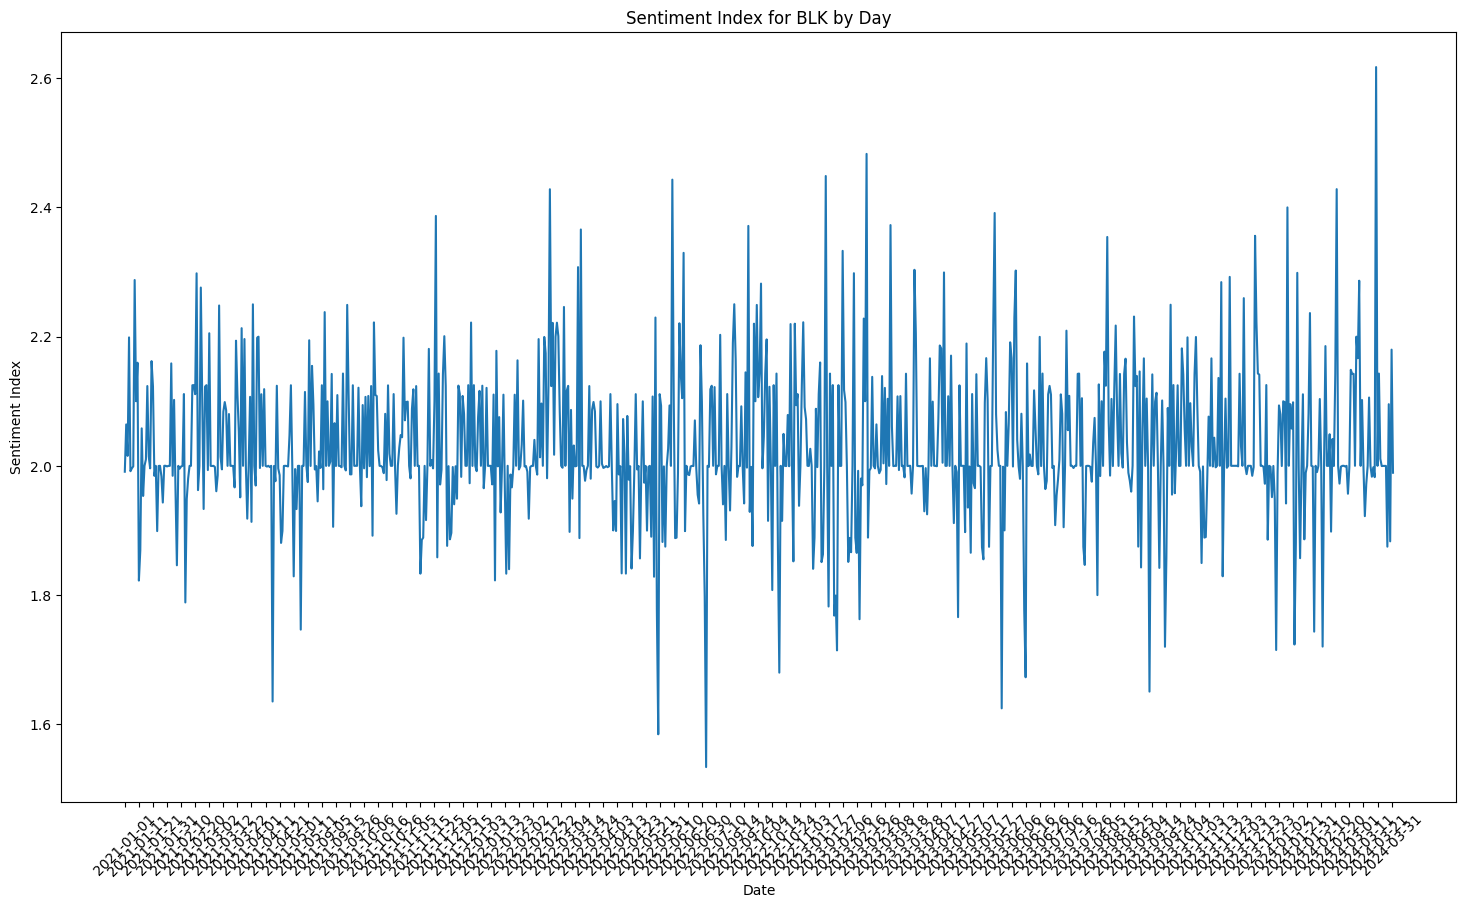

CRM
{'Neutral': 0.9996336698532104}
{'Neutral': 0.997246265411377}
{'Neutral': 0.9860631823539734}
{'Neutral': 0.7790237069129944}
{'Positive': 1.0}
{'Neutral': 0.9991810917854309}
{'Neutral': 0.9999943971633911}
{'Neutral': 0.9999926090240479}
{'Neutral': 0.9999841451644897}
{'Neutral': 0.999962568283081}
{'Neutral': 0.9999970197677612}
{'Neutral': 0.9999796152114868}
{'Neutral': 0.9999516010284424}
{'Neutral': 0.9964277148246765}
{'Neutral': 0.9999819993972778}
{'Neutral': 0.9994875192642212}
{'Positive': 0.999974250793457}
{'Neutral': 0.9966604709625244}
{'Neutral': 0.9995046854019165}
{'Neutral': 0.9999316930770874}
{'Neutral': 0.9998899698257446}
{'Neutral': 0.9964277148246765}
{'Neutral': 0.9999973773956299}
{'Neutral': 0.9999909400939941}
{'Neutral': 0.9998971223831177}
{'Neutral': 0.9999622106552124}
{'Neutral': 0.9999165534973145}
{'Neutral': 0.9999984502792358}
{'Neutral': 0.9998311996459961}
{'Neutral': 0.9998134970664978}
{'Neutral': 0.9979535341262817}
{'Neutral': 0.999995

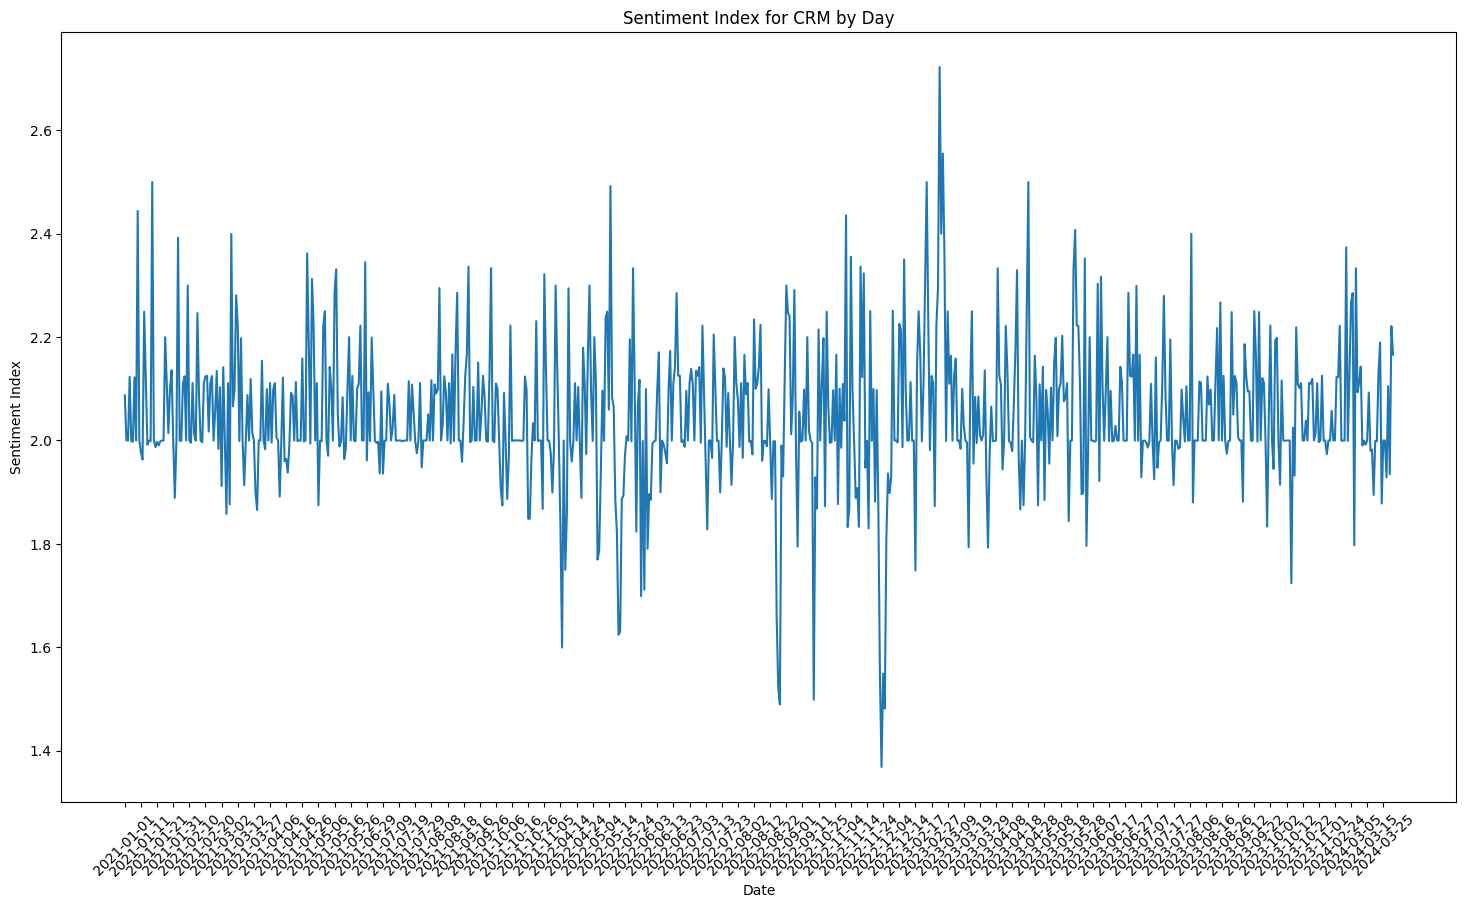

C
{'Neutral': 0.9999889135360718}
{'Negative': 0.9969538450241089}
{'Neutral': 0.9635403156280518}
{'Neutral': 0.9789808392524719}
{'Neutral': 0.7790237069129944}
{'Negative': 0.9999490976333618}
{'Positive': 0.9911898374557495}
{'Neutral': 0.9999796152114868}
{'Neutral': 0.9999891519546509}
{'Neutral': 0.8465367555618286}
{'Neutral': 0.9985129237174988}
{'Positive': 0.9986176490783691}
{'Positive': 0.9999222755432129}
{'Negative': 0.9999490976333618}
{'Neutral': 0.9423776865005493}
{'Positive': 0.9974015951156616}
{'Neutral': 0.9329599738121033}
{'Negative': 0.9999589920043945}
{'Positive': 0.85196852684021}
{'Neutral': 0.9999966621398926}
{'Neutral': 0.9999912977218628}
{'Neutral': 0.9999743700027466}
{'Positive': 0.9994267225265503}
{'Positive': 0.999370276927948}
{'Positive': 0.9987906813621521}
{'Positive': 0.9980098605155945}
{'Neutral': 0.9999535083770752}
{'Neutral': 0.99998939037323}
{'Neutral': 0.999997615814209}
{'Negative': 0.9973805546760559}
{'Neutral': 0.9999260902404785

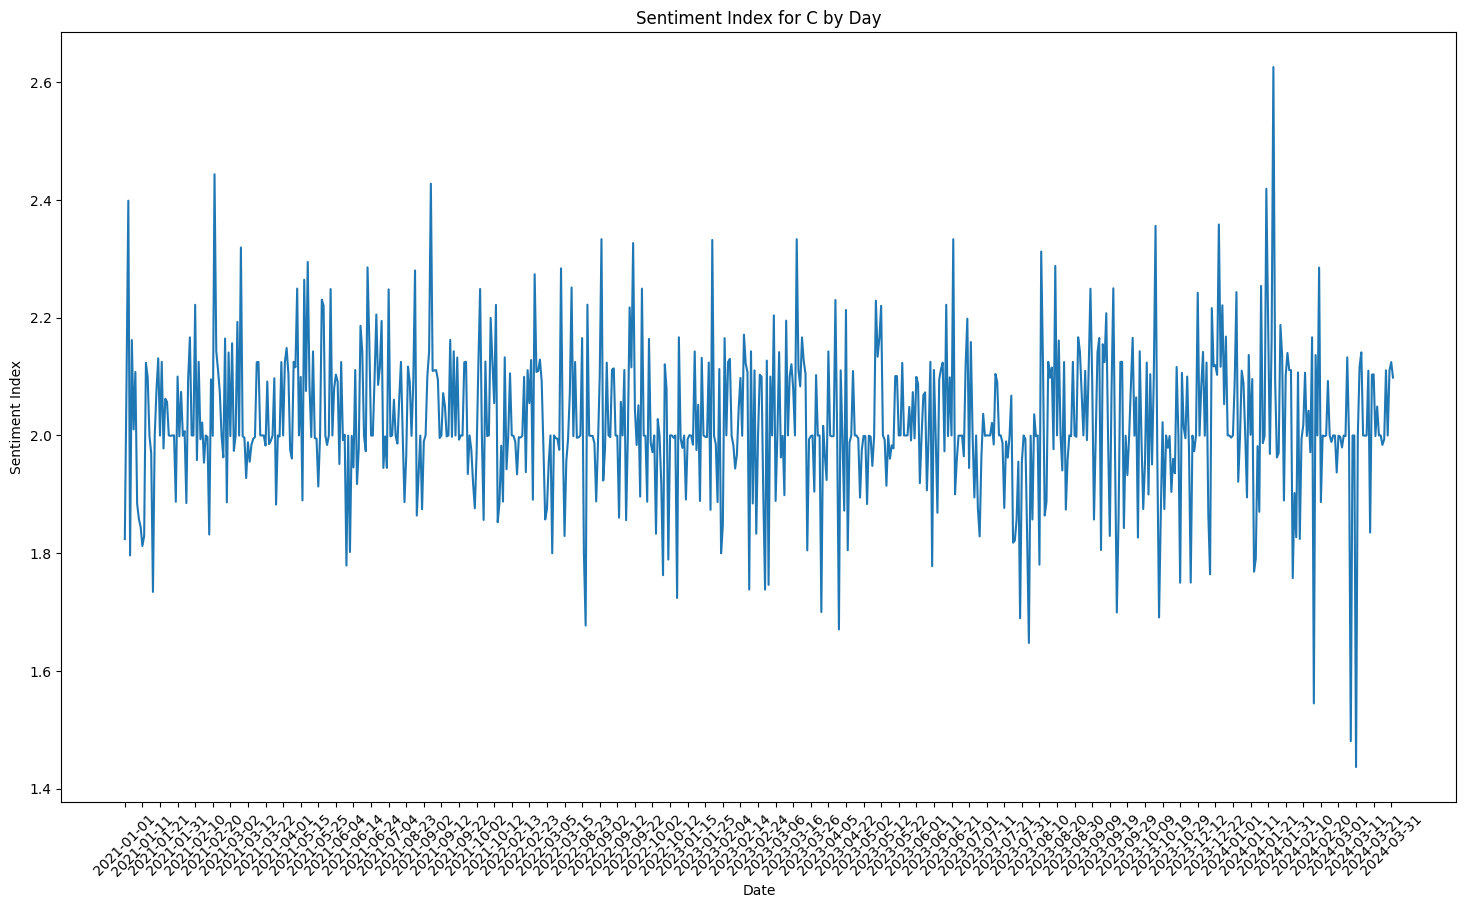

DE
{'Neutral': 0.9999769926071167}
{'Negative': 0.999061644077301}
{'Neutral': 0.9999654293060303}
{'Neutral': 0.9997466206550598}
{'Neutral': 0.9998719692230225}
{'Neutral': 0.9999969005584717}
{'Positive': 0.9108577370643616}
{'Neutral': 0.9998063445091248}
{'Positive': 0.9524310827255249}
{'Neutral': 0.999988317489624}
{'Neutral': 0.9999866485595703}
{'Neutral': 0.9996776580810547}
{'Neutral': 0.9984140396118164}
{'Neutral': 0.9985276460647583}
{'Neutral': 0.9990407824516296}
{'Neutral': 0.99997878074646}
{'Neutral': 0.9997970461845398}
{'Neutral': 0.9999270439147949}
{'Neutral': 0.9999521970748901}
{'Positive': 0.7372015118598938}
{'Neutral': 0.9999879598617554}
{'Positive': 0.999998927116394}
{'Positive': 1.0}
{'Neutral': 0.9999426603317261}
{'Positive': 0.9999889135360718}
{'Positive': 0.997808039188385}
{'Neutral': 0.999377429485321}
{'Positive': 0.9524310827255249}
{'Neutral': 0.9999003410339355}
{'Neutral': 0.9999217987060547}
{'Neutral': 0.9997774958610535}
{'Neutral': 0.9995

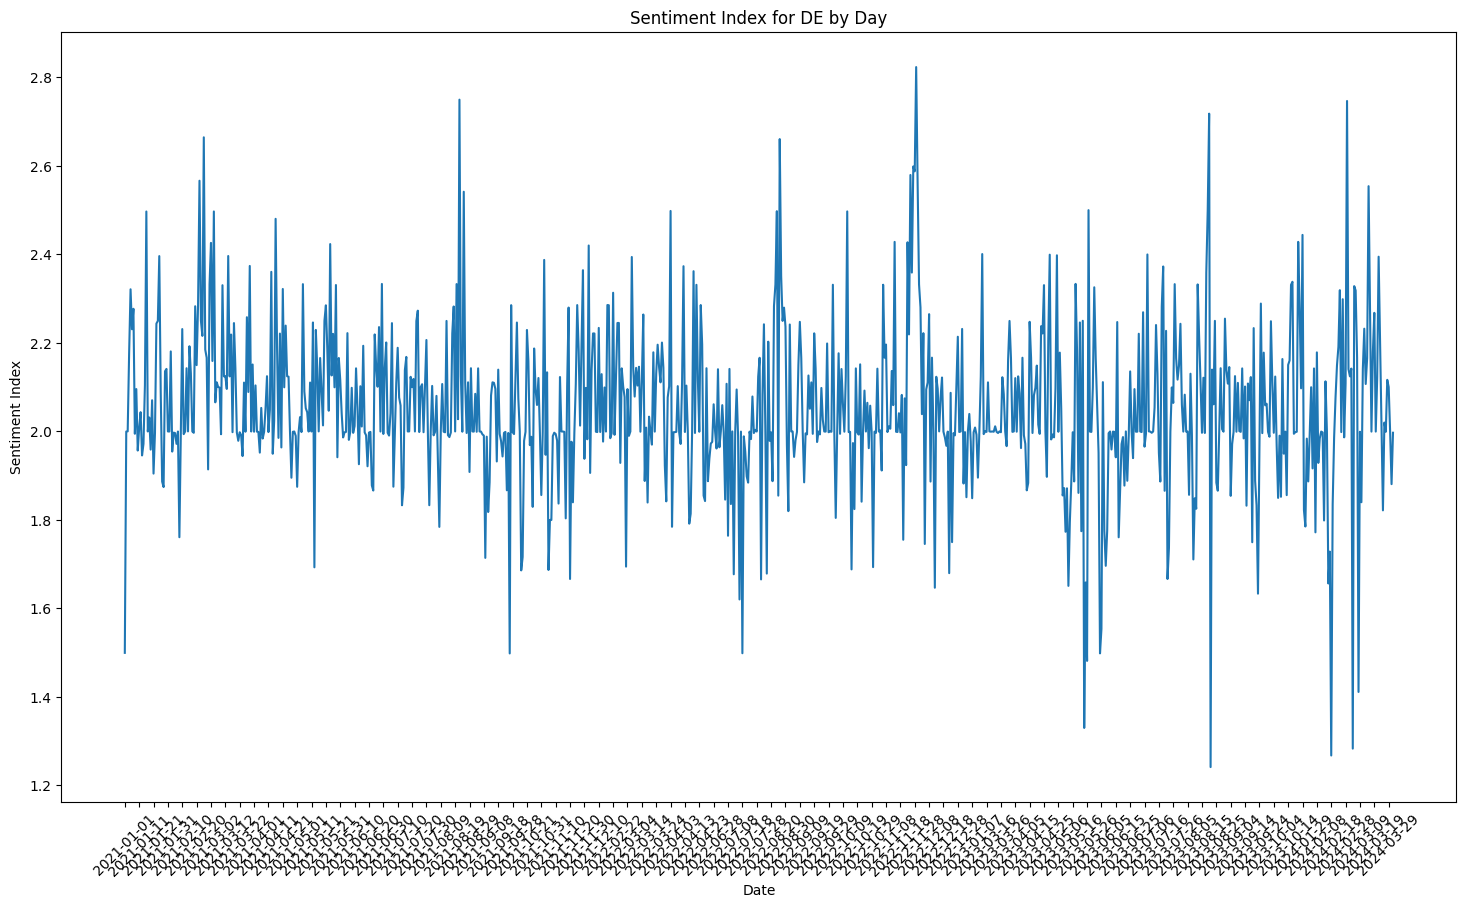

FDX
{'Positive': 0.9999845027923584}
{'Negative': 0.49482524394989014}
{'Positive': 0.9999690055847168}
{'Neutral': 0.9944223761558533}
{'Positive': 0.9998980760574341}
{'Neutral': 0.9999834299087524}
{'Neutral': 0.908621072769165}
{'Neutral': 0.9994621872901917}
{'Neutral': 0.9999933242797852}
{'Neutral': 0.9999692440032959}
{'Neutral': 0.9999964237213135}
{'Neutral': 0.9999982118606567}
{'Neutral': 0.9999755620956421}
{'Neutral': 0.9999911785125732}
{'Neutral': 0.999380350112915}
{'Neutral': 0.9996053576469421}
{'Neutral': 0.9845283627510071}
{'Neutral': 0.9997597336769104}
{'Neutral': 0.8320656418800354}
{'Neutral': 0.9996562004089355}
{'Positive': 0.9999998807907104}
{'Neutral': 0.9998030066490173}
{'Neutral': 0.9997751116752625}
{'Positive': 0.9999995231628418}
{'Neutral': 0.9999798536300659}
{'Neutral': 0.6368893980979919}
{'Positive': 0.9999986886978149}
{'Neutral': 0.9998737573623657}
{'Neutral': 0.9994882345199585}
{'Neutral': 0.999944806098938}
{'Negative': 0.9713611602783203

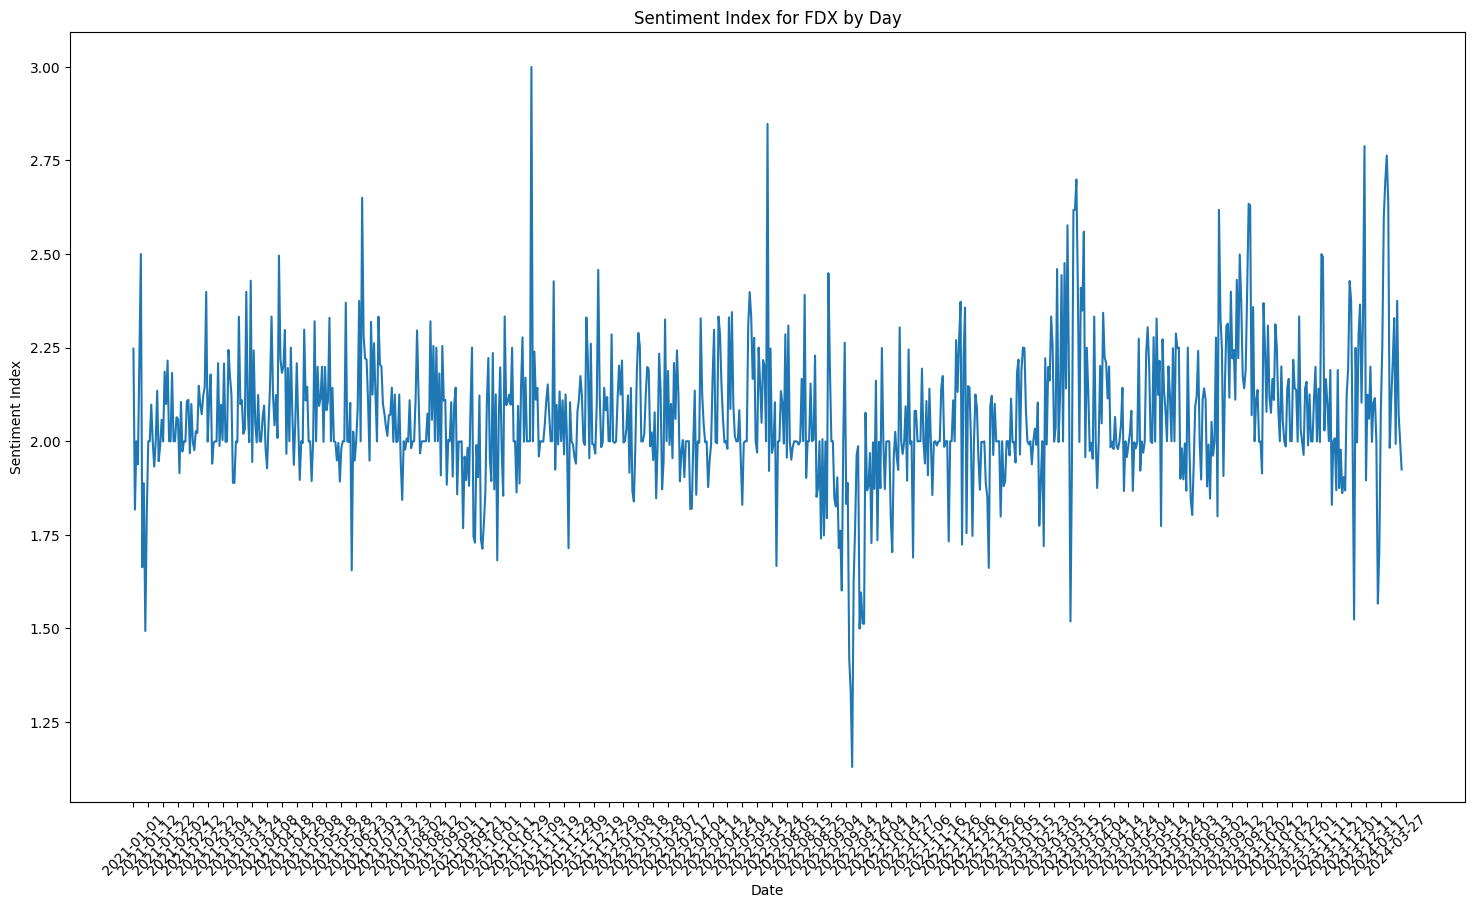

GE
{'Neutral': 0.9950348138809204}
{'Positive': 0.9999929666519165}
{'Positive': 1.0}
{'Positive': 0.9999278783798218}
{'Neutral': 0.9999321699142456}
{'Neutral': 0.9984868764877319}
{'Neutral': 0.9999454021453857}
{'Neutral': 0.999704897403717}
{'Positive': 0.9999898672103882}
{'Neutral': 0.9999847412109375}
{'Neutral': 0.9984837174415588}
{'Neutral': 0.9966505169868469}
{'Neutral': 0.998561680316925}
{'Neutral': 0.9994162321090698}
{'Neutral': 0.9998571872711182}
{'Neutral': 0.9995154142379761}
{'Neutral': 0.9996579885482788}
{'Neutral': 0.9983080625534058}
{'Neutral': 0.9997828602790833}
{'Neutral': 0.9998635053634644}
{'Neutral': 0.9977586269378662}
{'Neutral': 0.9996336698532104}
{'Neutral': 0.9997618794441223}
{'Neutral': 0.999954104423523}
{'Neutral': 0.9984978437423706}
{'Neutral': 0.9980700612068176}
{'Neutral': 0.9999336004257202}
{'Neutral': 0.9999611377716064}
{'Neutral': 0.9988526105880737}
{'Positive': 0.9408287405967712}
{'Neutral': 0.9994810223579407}
{'Positive': 0.972

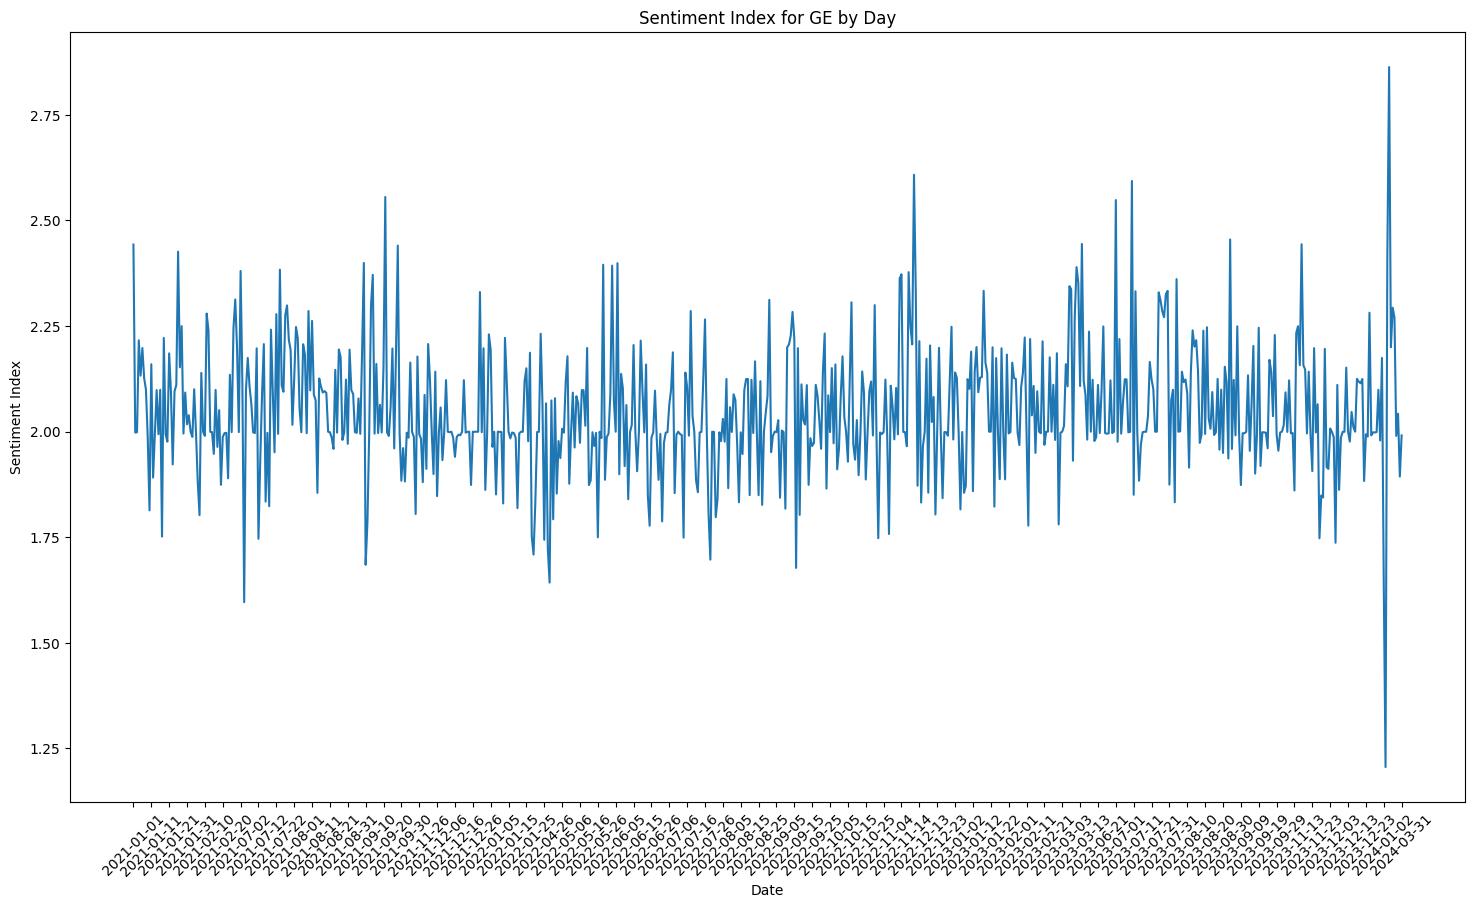

GOOGL
{'Neutral': 0.9999970197677612}
{'Neutral': 0.999987006187439}
{'Positive': 0.7514350414276123}
{'Positive': 0.9651166796684265}
{'Positive': 1.0}
{'Positive': 0.9984877109527588}
{'Neutral': 0.9999327659606934}
{'Positive': 0.971690833568573}
{'Neutral': 0.8620019555091858}
{'Neutral': 0.8877176642417908}
{'Positive': 0.9999997615814209}
{'Positive': 0.9999550580978394}
{'Neutral': 0.9999843835830688}
{'Neutral': 0.9999550580978394}
{'Neutral': 0.9998968839645386}
{'Neutral': 0.9999914169311523}
{'Neutral': 0.9999912977218628}
{'Neutral': 0.9999576807022095}
{'Neutral': 0.9990573525428772}
{'Neutral': 0.9999628067016602}
{'Neutral': 0.99998939037323}
{'Positive': 0.9897127151489258}
{'Neutral': 0.999992847442627}
{'Neutral': 0.9999971389770508}
{'Neutral': 0.6476170420646667}
{'Neutral': 0.9998947381973267}
{'Neutral': 0.9999210834503174}
{'Neutral': 0.9999796152114868}
{'Neutral': 0.9999585151672363}
{'Neutral': 0.9999912977218628}
{'Neutral': 0.999987006187439}
{'Neutral': 0.9

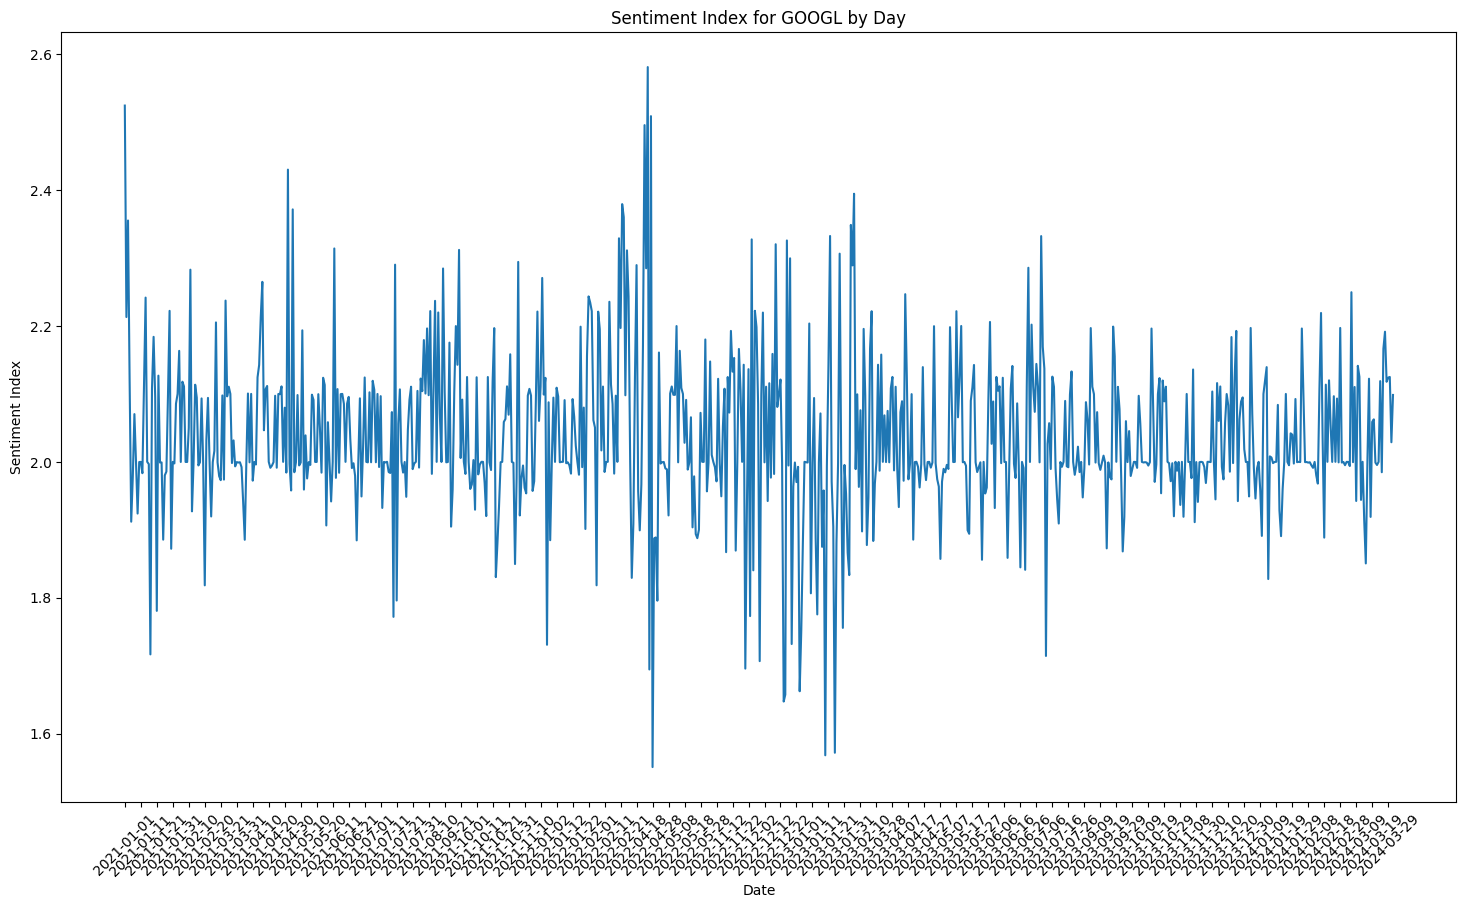

GS
{'Neutral': 0.9991174340248108}
{'Neutral': 0.9998875856399536}
{'Positive': 0.9998598098754883}
{'Neutral': 0.9954843521118164}
{'Negative': 0.999982476234436}
{'Positive': 0.9999759197235107}
{'Positive': 0.9997848868370056}
{'Neutral': 0.9983214735984802}
{'Positive': 0.9988235831260681}
{'Neutral': 0.9999884366989136}
{'Positive': 0.9997227787971497}
{'Negative': 0.999982476234436}
{'Neutral': 0.9998027682304382}
{'Positive': 0.9998237490653992}
{'Neutral': 0.5917114615440369}
{'Positive': 0.9998511075973511}
{'Neutral': 0.9999862909317017}
{'Neutral': 0.9999957084655762}
{'Neutral': 0.9999827146530151}
{'Neutral': 0.9999678134918213}
{'Positive': 1.0}
{'Negative': 0.9999845027923584}
{'Neutral': 0.9994165897369385}
{'Neutral': 0.9999905824661255}
{'Neutral': 0.9999936819076538}
{'Neutral': 0.9996823072433472}
{'Neutral': 0.6685091257095337}
{'Positive': 0.999985933303833}
{'Neutral': 0.9996129870414734}
{'Neutral': 0.9998267292976379}
{'Positive': 0.942737340927124}
{'Neutral':

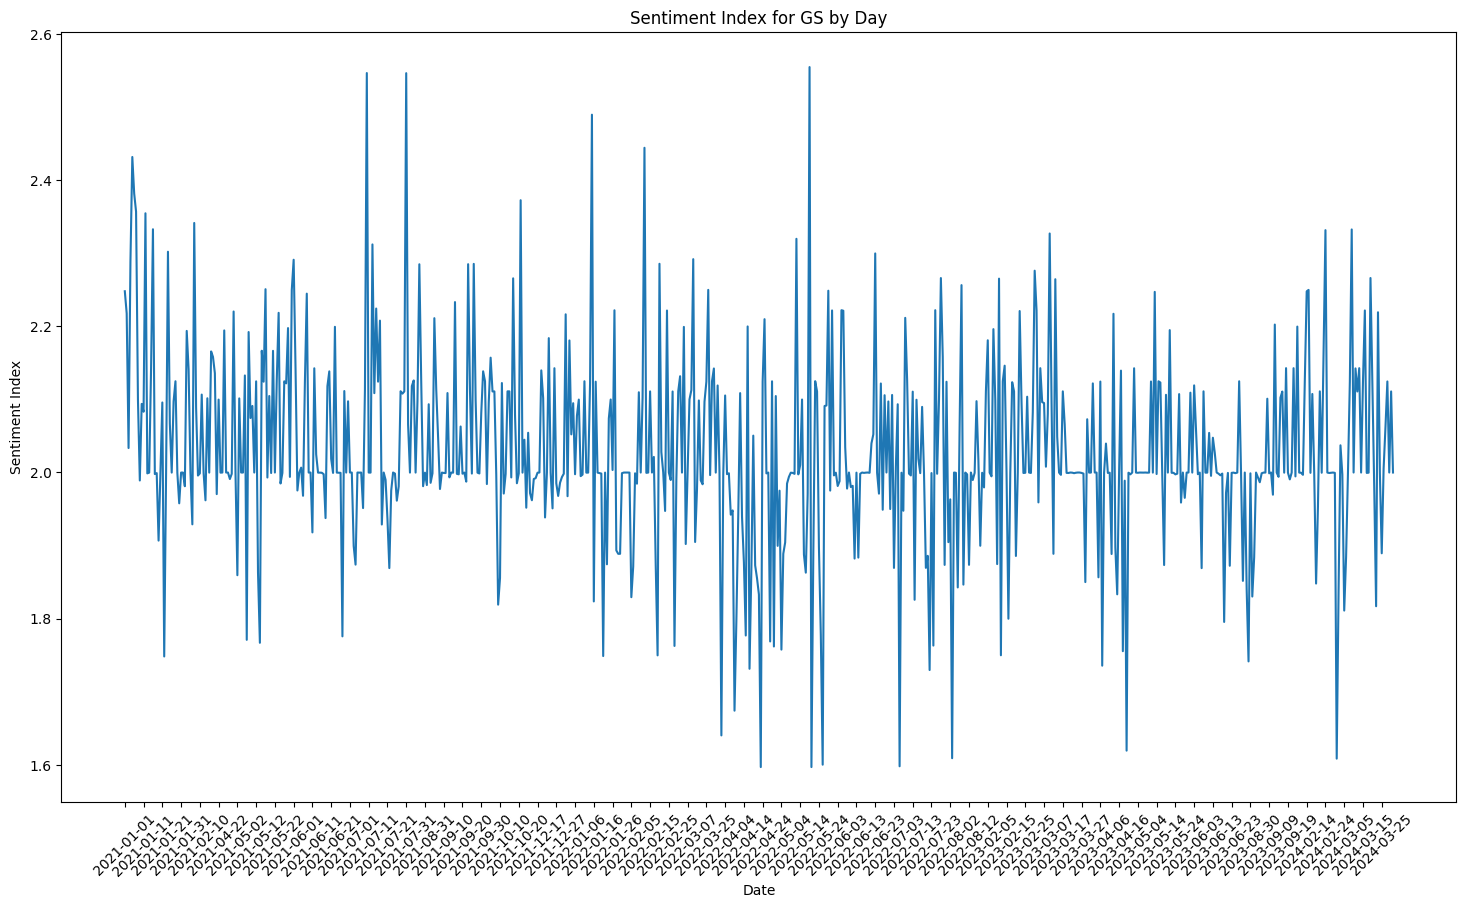

HON
{'Positive': 0.5404487252235413}
{'Neutral': 0.9999843835830688}
{'Neutral': 0.9997321963310242}
{'Neutral': 0.9999938011169434}
{'Neutral': 0.9997528195381165}
{'Neutral': 0.999728262424469}
{'Neutral': 0.9999762773513794}
{'Neutral': 0.9999953508377075}
{'Neutral': 0.99998939037323}
{'Positive': 0.5404487252235413}
{'Neutral': 0.9999971389770508}
{'Neutral': 0.999983549118042}
{'Neutral': 0.9999948740005493}
{'Neutral': 0.9997168183326721}
{'Positive': 0.998042106628418}
{'Neutral': 0.999977707862854}
{'Neutral': 0.998765230178833}
{'Neutral': 0.9999977350234985}
{'Neutral': 0.9999803304672241}
{'Positive': 0.9998912811279297}
{'Neutral': 0.9999964237213135}
{'Neutral': 0.9814241528511047}
{'Neutral': 0.9471591711044312}
{'Neutral': 0.9999812841415405}
{'Neutral': 0.9998403787612915}
{'Neutral': 0.9999927282333374}
{'Neutral': 0.999993085861206}
{'Neutral': 0.9999953508377075}
{'Neutral': 0.9994519352912903}
{'Neutral': 0.9995427131652832}
{'Neutral': 0.9999123811721802}
{'Neutra

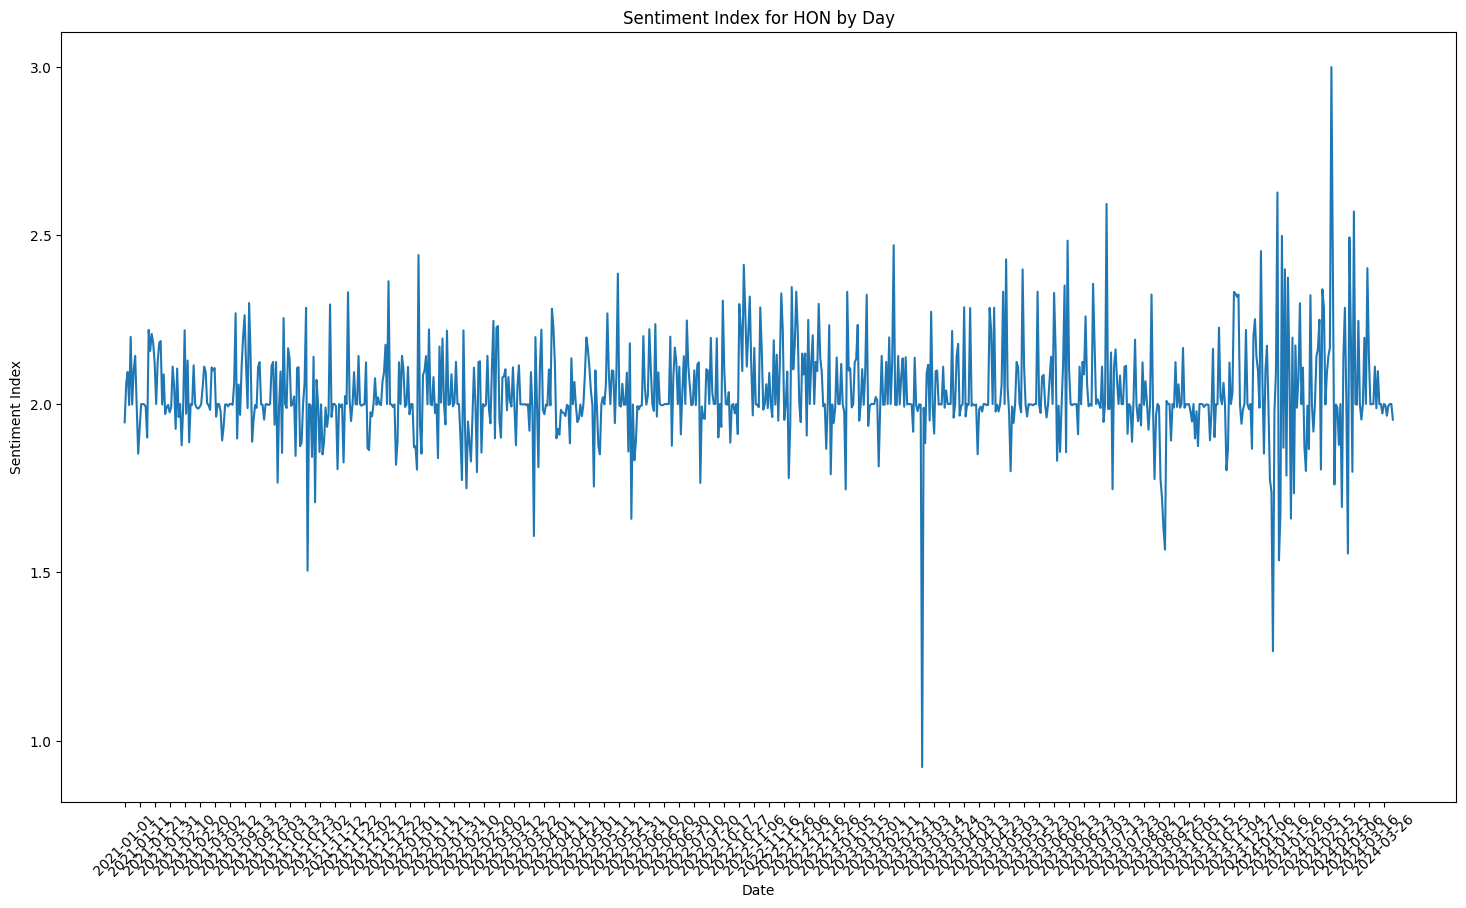

INTC
{'Neutral': 0.9998499155044556}
{'Neutral': 0.9999212026596069}
{'Positive': 1.0}
{'Neutral': 0.9999669790267944}
{'Neutral': 0.9999828338623047}
{'Positive': 0.9999898672103882}
{'Neutral': 0.9989627599716187}
{'Neutral': 0.9992402791976929}
{'Neutral': 0.9992445707321167}
{'Neutral': 0.9949294328689575}
{'Positive': 0.9949384927749634}
{'Neutral': 0.9999696016311646}
{'Neutral': 0.9999688863754272}
{'Neutral': 0.9991999268531799}
{'Neutral': 0.9991670846939087}
{'Neutral': 0.9939588308334351}
{'Neutral': 0.9998623132705688}
{'Neutral': 0.954644501209259}
{'Positive': 0.9991655349731445}
{'Positive': 0.9999991655349731}
{'Neutral': 0.9995256662368774}
{'Neutral': 0.9993191957473755}
{'Neutral': 0.9999984502792358}
{'Neutral': 0.9999978542327881}
{'Neutral': 0.9999724626541138}
{'Neutral': 0.9999992847442627}
{'Neutral': 0.895480215549469}
{'Positive': 0.9991229176521301}
{'Neutral': 0.9985172152519226}
{'Positive': 0.9999963045120239}
{'Neutral': 0.9993168115615845}
{'Neutral': 0

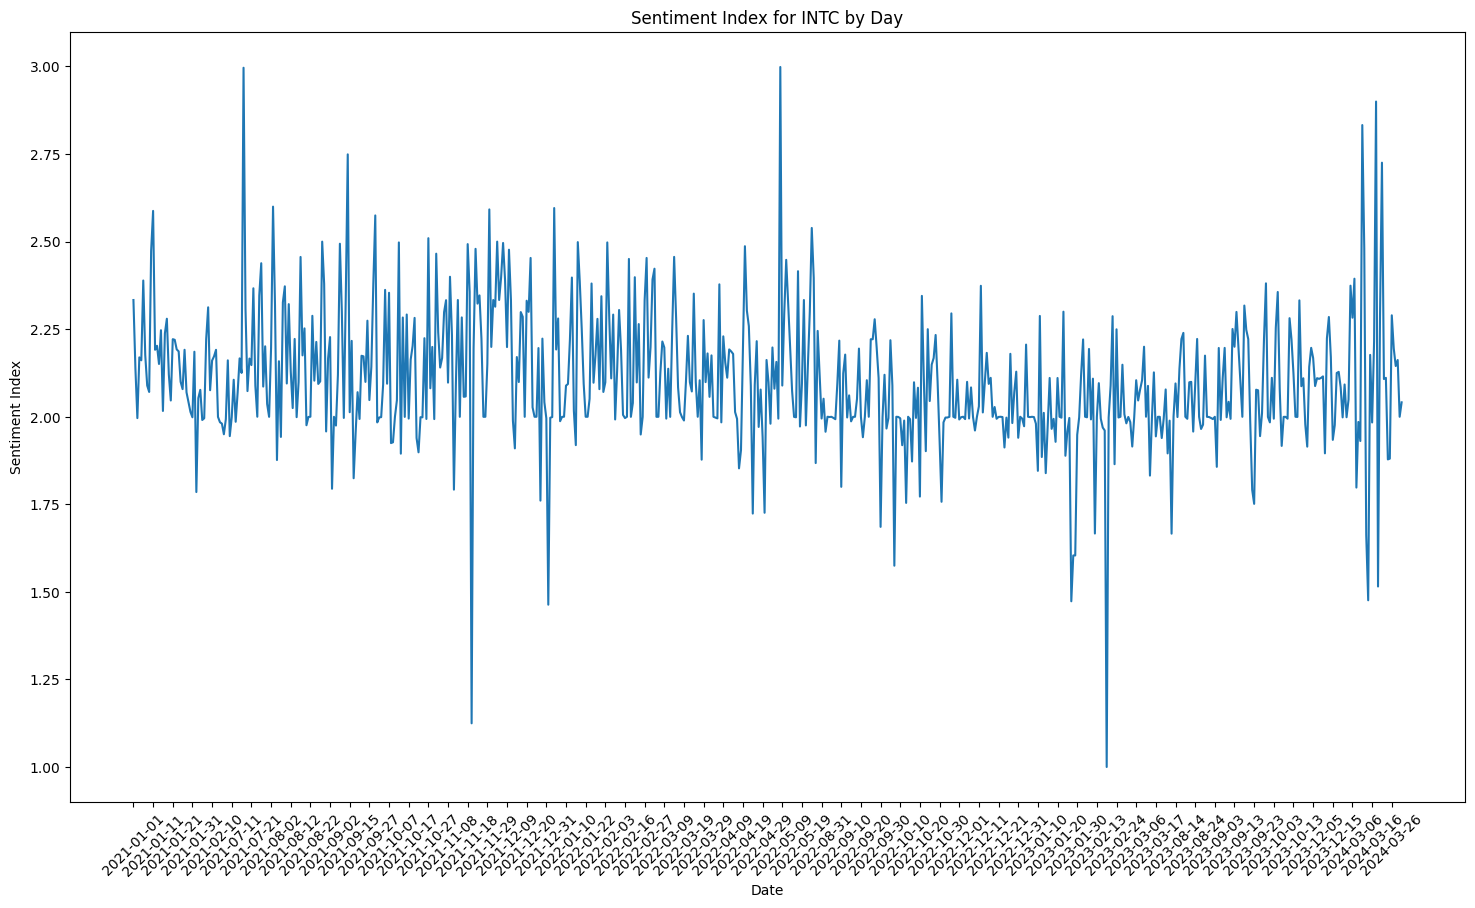

JPM
{'Neutral': 0.9999904632568359}
{'Neutral': 0.9999783039093018}
{'Neutral': 0.9999955892562866}
{'Neutral': 0.9999759197235107}
{'Neutral': 0.9999970197677612}
{'Neutral': 0.9998469352722168}
{'Neutral': 0.9999979734420776}
{'Neutral': 0.9998674392700195}
{'Neutral': 0.9999963045120239}
{'Neutral': 0.9999951124191284}
{'Neutral': 0.5689253807067871}
{'Neutral': 0.9999794960021973}
{'Neutral': 0.998895525932312}
{'Neutral': 0.9999178647994995}
{'Neutral': 0.9999887943267822}
{'Neutral': 0.9999923706054688}
{'Neutral': 0.9999957084655762}
{'Neutral': 0.9999743700027466}
{'Neutral': 0.9999861717224121}
{'Neutral': 0.9999386072158813}
{'Positive': 0.9997081160545349}
{'Neutral': 0.6232532262802124}
{'Neutral': 0.9999871253967285}
{'Neutral': 0.999854564666748}
{'Neutral': 0.9999912977218628}
{'Neutral': 0.8252910375595093}
{'Neutral': 0.9999911785125732}
{'Neutral': 0.9967235922813416}
{'Neutral': 0.999634861946106}
{'Neutral': 0.999854564666748}
{'Neutral': 0.7900636792182922}
{'Neutr

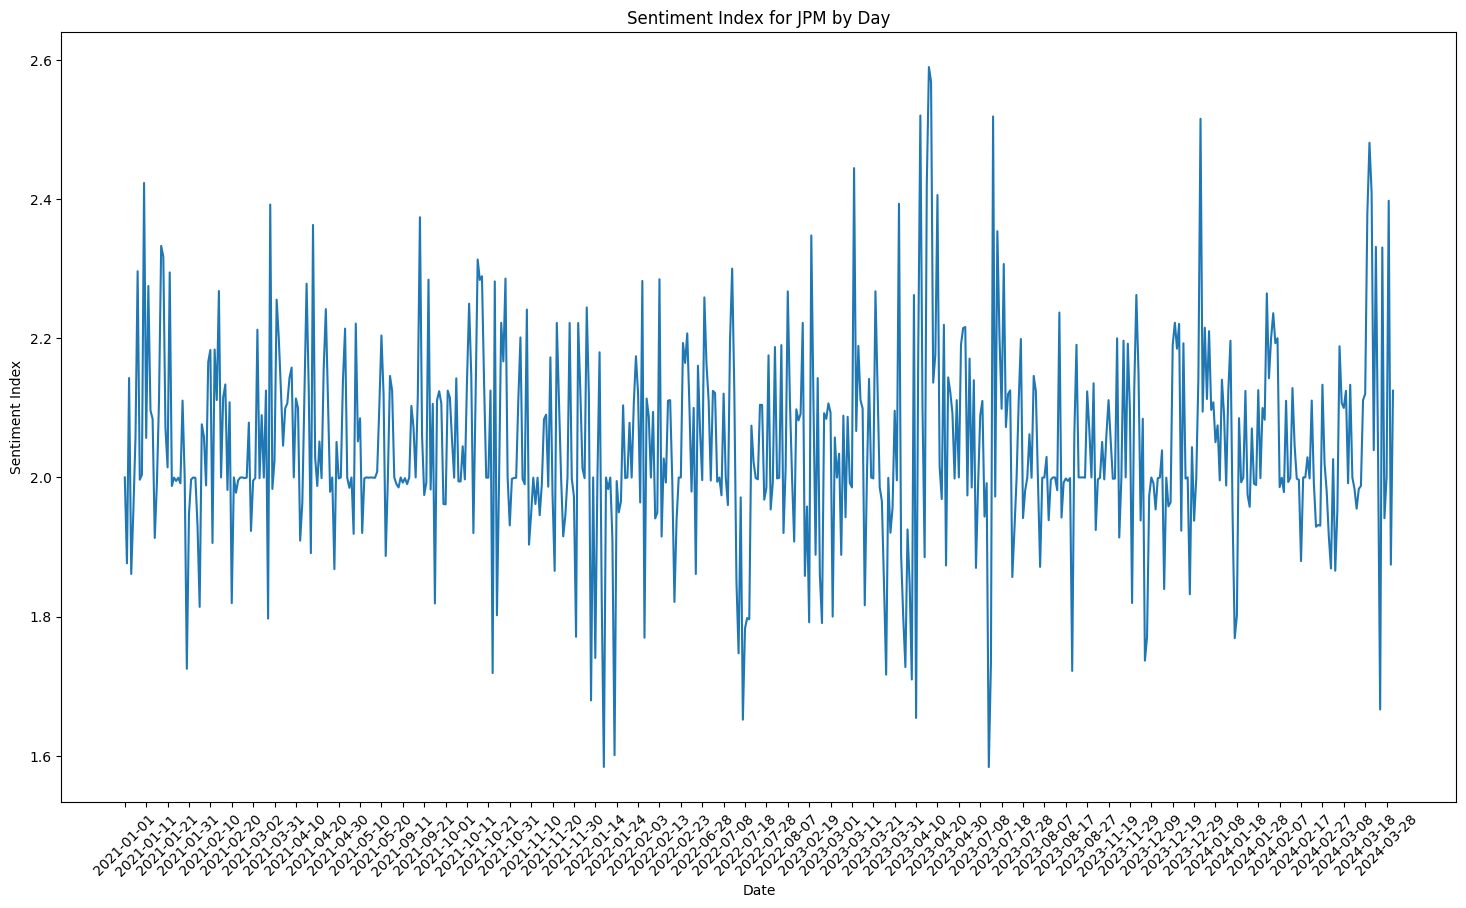

MS
{'Neutral': 0.9997263550758362}
{'Neutral': 0.9997112154960632}
{'Neutral': 0.9998817443847656}
{'Positive': 0.9999665021896362}
{'Neutral': 0.9974141120910645}
{'Neutral': 0.9999744892120361}
{'Neutral': 0.9999985694885254}
{'Neutral': 0.9999783039093018}
{'Neutral': 0.8093615770339966}
{'Neutral': 0.9999336004257202}
{'Neutral': 0.9999829530715942}
{'Neutral': 0.9999810457229614}
{'Neutral': 0.9976085424423218}
{'Neutral': 0.999968409538269}
{'Positive': 0.9258607625961304}
{'Neutral': 0.9999927282333374}
{'Neutral': 0.9999642372131348}
{'Neutral': 0.9999693632125854}
{'Neutral': 0.9999855756759644}
{'Neutral': 0.9999452829360962}
{'Neutral': 0.9999924898147583}
{'Neutral': 0.9999732971191406}
{'Neutral': 0.9998750686645508}
{'Neutral': 0.999955415725708}
{'Neutral': 0.9998838901519775}
{'Positive': 0.9997429251670837}
{'Positive': 0.9999468326568604}
{'Neutral': 0.9999196529388428}
{'Neutral': 0.9998726844787598}
{'Neutral': 0.9930834770202637}
{'Positive': 0.9164358973503113}
{'

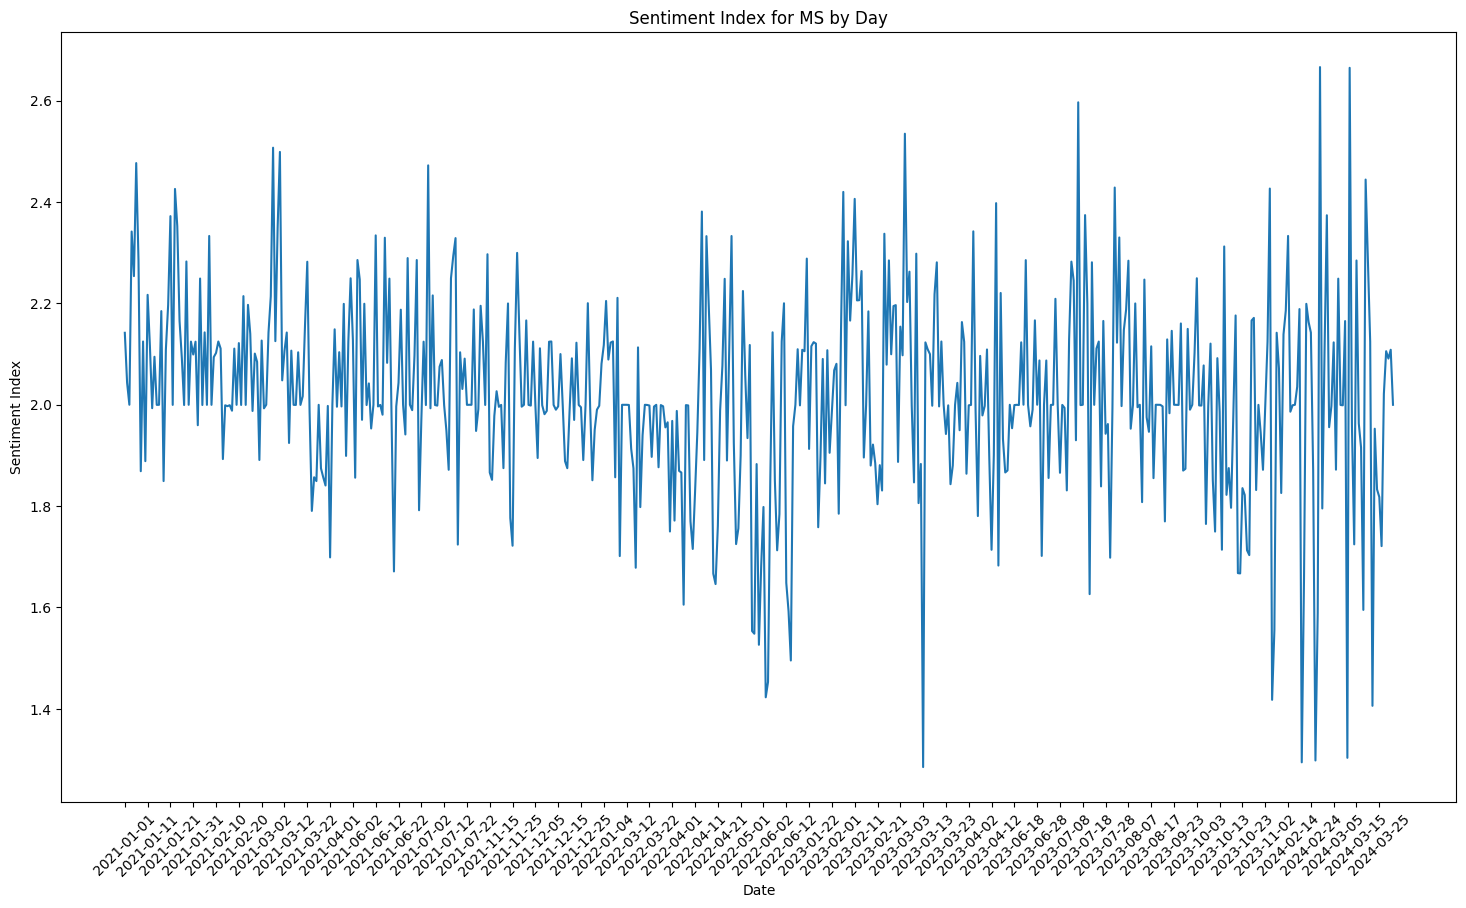

UNP
{'Positive': 0.999998927116394}
{'Neutral': 0.9999622106552124}
{'Neutral': 0.9999622106552124}
{'Neutral': 0.9999922513961792}
{'Neutral': 0.999988317489624}
{'Neutral': 0.9999315738677979}
{'Neutral': 0.999991774559021}
{'Neutral': 0.9999172687530518}
{'Neutral': 0.9977442026138306}
{'Neutral': 0.9998838901519775}
{'Neutral': 0.9999922513961792}
{'Neutral': 0.9999284744262695}
{'Neutral': 0.9999864101409912}
{'Positive': 0.9961599111557007}
{'Neutral': 0.9999947547912598}
{'Neutral': 0.9998571872711182}
{'Neutral': 0.9930949211120605}
{'Neutral': 0.999993085861206}
{'Neutral': 0.9999922513961792}
{'Neutral': 0.999980092048645}
{'Neutral': 0.9999734163284302}
{'Positive': 0.9999995231628418}
{'Neutral': 0.9997771382331848}
{'Positive': 0.9909398555755615}
{'Neutral': 0.9994584918022156}
{'Neutral': 0.9878381490707397}
{'Neutral': 0.9999749660491943}
{'Neutral': 0.9995567202568054}
{'Neutral': 0.9999916553497314}
{'Positive': 0.8399084806442261}
{'Neutral': 0.9999657869338989}
{'Ne

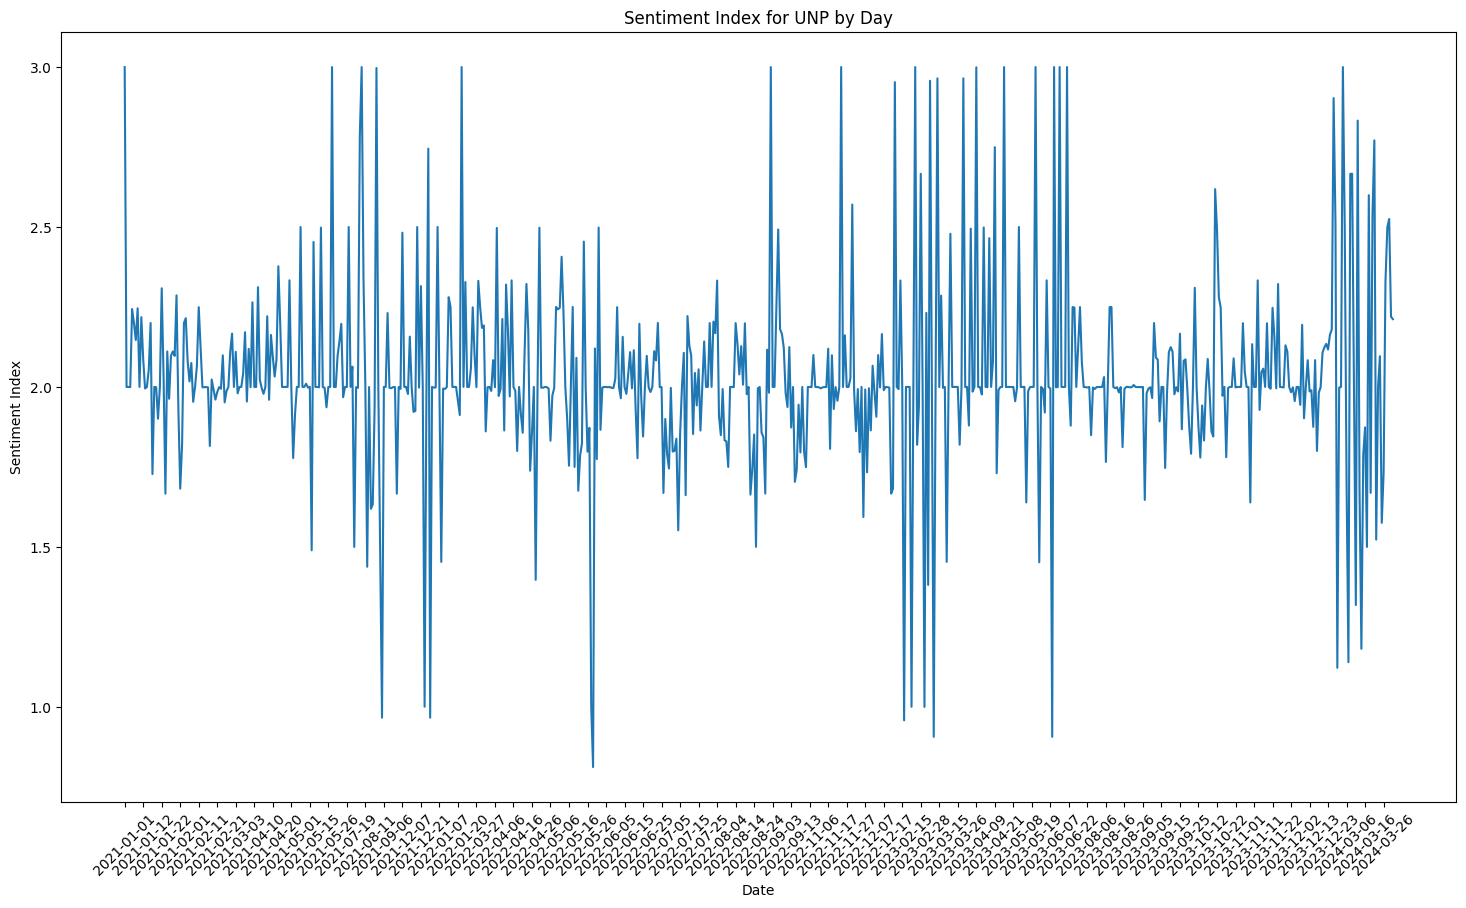

WFC
{'Neutral': 0.9998947381973267}
{'Positive': 0.9991039633750916}
{'Neutral': 0.9999970197677612}
{'Positive': 1.0}
{'Neutral': 0.9999997615814209}
{'Neutral': 0.9965044260025024}
{'Neutral': 0.9999160766601562}
{'Neutral': 0.9989364743232727}
{'Neutral': 0.9999896287918091}
{'Positive': 0.8503908514976501}
{'Neutral': 0.9999979734420776}
{'Neutral': 0.9997683167457581}
{'Positive': 0.9999499320983887}
{'Neutral': 0.9999724626541138}
{'Neutral': 0.999996542930603}
{'Neutral': 0.9999927282333374}
{'Positive': 0.99996018409729}
{'Neutral': 0.9998950958251953}
{'Neutral': 0.9999386072158813}
{'Neutral': 0.9999969005584717}
{'Neutral': 0.9999964237213135}
{'Neutral': 0.9982341527938843}
{'Neutral': 0.9999945163726807}
{'Neutral': 0.9999274015426636}
{'Neutral': 0.9999936819076538}
{'Neutral': 0.9997418522834778}
{'Neutral': 0.9973602890968323}
{'Neutral': 0.9994387030601501}
{'Positive': 0.9999910593032837}
{'Positive': 0.9941410422325134}
{'Neutral': 0.9972707629203796}
{'Neutral': 0.9

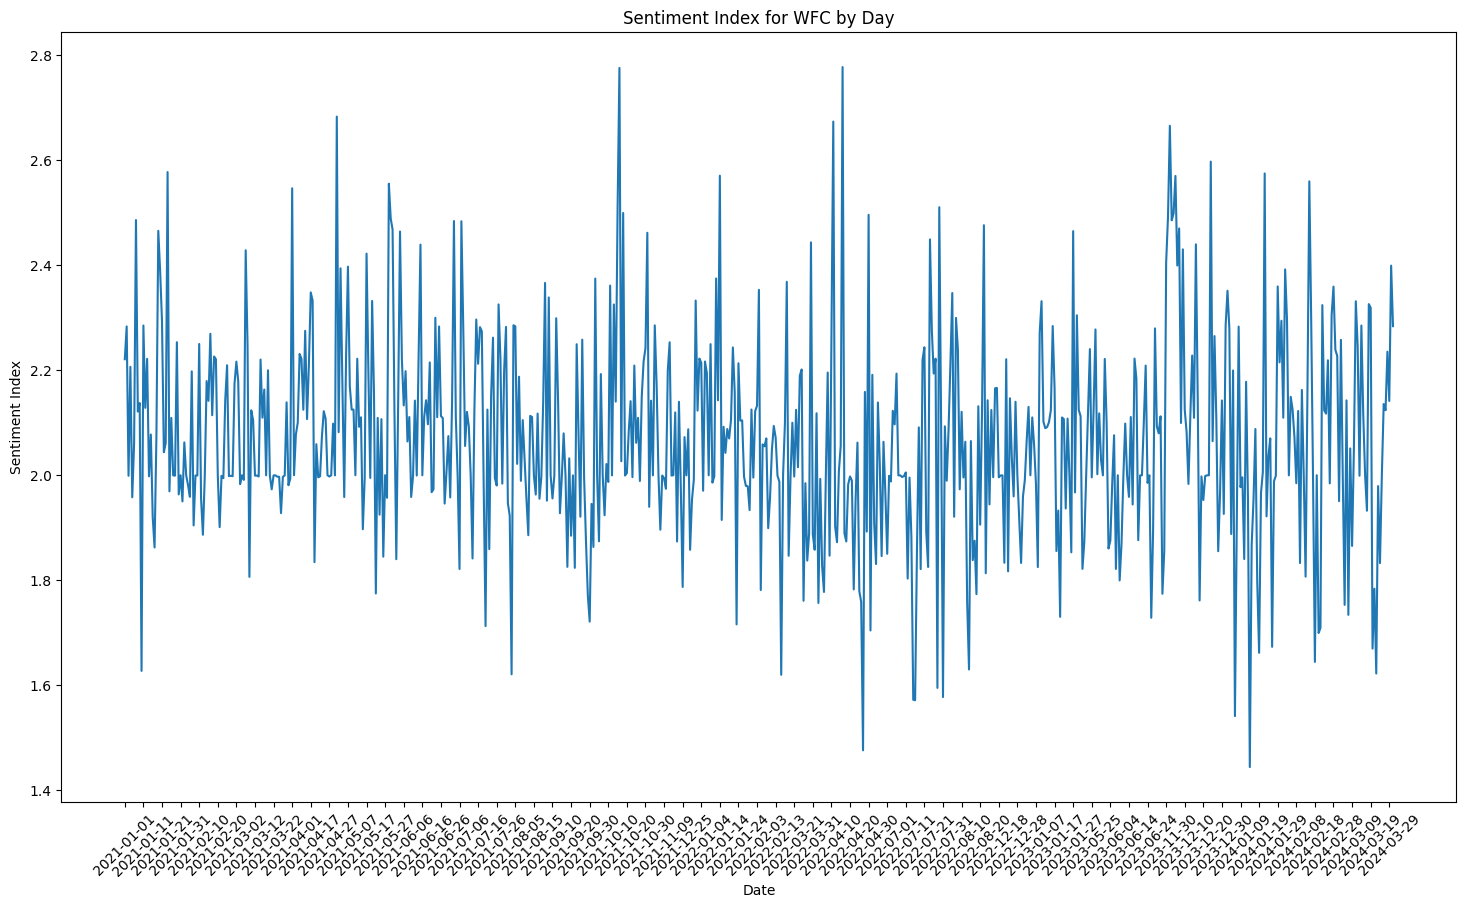

In [37]:
import glob
# Get a list of all CSV files in the "newsdata" folder
csv_files = glob.glob('newsdata/*.csv')

for file_name in csv_files:
    companyName = file_name.split('_')[0]
    companyName = companyName.split('\\')[1]
    print(companyName)

    df = pd.read_csv(file_name)

    df = processData(df)
    df = labelExtract(df)
    dayData = sentimentIndexByDay(df, companyName)
    Plot(dayData, companyName)


Moving Average

In [9]:
!pip install nbformat

  Obtaining dependency information for nbformat from https://files.pythonhosted.org/packages/a9/82/0340caa499416c78e5d8f5f05947ae4bc3cba53c9f038ab6e9ed964e22f1/nbformat-5.10.4-py3-none-any.whl.metadata
  Obtaining dependency information for fastjsonschema>=2.15 from https://files.pythonhosted.org/packages/9c/b9/79691036d4a8f9857e74d1728b23f34f583b81350a27492edda58d5604e1/fastjsonschema-2.19.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


date  Sentiment_index  Moving_Average
0    2021-01-01         2.169724             NaN
1    2021-01-02         2.313737             NaN
2    2021-01-03         2.043799             NaN
3    2021-01-04         1.837105             NaN
4    2021-01-05         1.970936             NaN
..          ...              ...             ...
556  2024-03-27         2.107532        2.037936
557  2024-03-28         1.789584        2.027496
558  2024-03-29         1.991708        2.027458
559  2024-03-30         1.951463        2.026721
560  2024-03-31         2.025257        2.027864

[561 rows x 3 columns]

In [36]:
import pandas as pd

df = pd.read_csv('AAPL_sentiment_index.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Calculate the moving average with a window size of 7
df['MA7'] = df['Sentiment_index'].rolling(window=7).mean()
df['MA14'] = df['Sentiment_index'].rolling(window=14).mean()
df['MA31'] = df['Sentiment_index'].rolling(window=31).mean()
display(df.tail())
df = df.dropna()

df.info()
df.reset_index(inplace=True,drop=True)

Sentiment_index       MA7      MA14      MA31
date                                                     
2024-03-27         2.107532  2.002024  2.056405  2.037936
2024-03-28         1.789584  1.972104  2.028544  2.027496
2024-03-29         1.991708  1.955748  2.026370  2.027458
2024-03-30         1.951463  1.973768  2.014282  2.026721
2024-03-31         2.025257  1.995227  1.995015  2.027864

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 531 entries, 2021-01-31 to 2024-03-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sentiment_index  531 non-null    float64
 1   MA7              531 non-null    float64
 2   MA14             531 non-null    float64
 3   MA31             531 non-null    float64
dtypes: float64(4)
memory usage: 20.7 KB


In [39]:

import plotly.express as px

px.line(df.dropna(axis=0), title='Sentiment Index Moving Average for AAPL')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=Sentiment_index<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Sentiment_index',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Sentiment_index',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([  0,   1,   2, ..., 528, 529, 530], dtype=int64),
              'xaxis': 'x',
              'y': array([2.0895133 , 2.19486096, 2.1225421 , ..., 1.99170759, 1.95146329,
                          2.02525734]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=MA7<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'MA7',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'MA7',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([  0,   1,   2, ..., 528, 529, 530], dtype=int64),
              'xaxis': 'x',
              'y': array([2.00636184, 2.03434677, 2.03865846, ..., 1.95574819, 1.97376799,
                          1.99522673]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=MA14<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'MA14',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'MA14',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([  0,   1,   2, ..., 528, 529, 530], dtype=int64),
              'xaxis': 'x',
              'y': array([2.01521316, 2.03517707, 2.04397061, ..., 2.02637009, 2.01428211,
                          1.99501532]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=MA31<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'MA31',
              'line': {'color': '#ab63fa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'MA31',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([  0,   1,   2, ..., 528, 529, 530], dtype=int64),
              'xaxis': 'x',
              'y': array([2.00922548, 2.01003636, 2.0038688 , ..., 2.02745808, 2.02672132,
                          2.02786402]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sentiment Index Moving Average for AAPL'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'index'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

In [35]:
px.line(df, title='Sentiment Index Moving Average for AAPL')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=Sentiment_index<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Sentiment_index',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Sentiment_index',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([  0,   1,   2, ..., 552, 553, 554], dtype=int64),
              'xaxis': 'x',
              'y': array([1.99899793, 1.97874692, 2.19699545, ..., 1.99170759, 1.95146329,
                          2.02525734]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Moving_Average<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Moving_Average',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Moving_Average',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([  0,   1,   2, ..., 552, 553, 554], dtype=int64),
              'xaxis': 'x',
              'y': array([2.0435852 , 2.01630282, 1.99962551, ..., 1.95574819, 1.97376799,
                          1.99522673]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Sentiment Index Moving Average for AAPL'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'index'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

In [56]:
dfapp = pd.read_csv("AAPL_sentiment_index.csv")

#filtered_df = dfapp[(dfapp['Sentiment_index'] > 2.1) & (dfapp['Sentiment_index'] < 1.9)]
filtered_df = dfapp[dfapp['Sentiment_index'] > 2.4]
filtered_df
#filtered_df.to_csv("filtered_sentiment_index.csv", index=False)

date  Sentiment_index
333  2022-10-30         2.498549
345  2022-11-11         2.461711
346  2022-11-12         2.544157
374  2023-03-05         2.590642
402  2023-04-02         2.484810

In [49]:
dfapp.head()

date  Sentiment_index
0  2021-01-01         2.169724
1  2021-01-02         2.313737
2  2021-01-03         2.043799
3  2021-01-04         1.837105
4  2021-01-05         1.970936